In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from torchsummary import summary

In [5]:
from scipy.optimize import curve_fit
from collections import namedtuple

In [6]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [7]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plotxyze, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [8]:
from pymono.cnn_func import  CNN

In [9]:
from pymono.cnn_func import  CNN_basic, CNN_3x3

In [10]:
from pymono.cnn_func import ResNet10

In [11]:
from pymono.cnn_fit import fit_coord, plotfxyz

In [12]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [13]:
from pymono.cnn_eval import evaluate_cnn, cnn_evaluation, single_run, train_cnn
from pymono.cnn_eval import evaluate_cnnx, single_runx, train_cnnx

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [15]:
data_dir = Path(os.environ['MONOLITH_DATA'])

In [16]:
crystal = os.path.join(data_dir,"CsI_3x3_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX")

In [17]:
def cnn4L(chi=64, ck=[3,3,3,2], cp=[1,1,1,0], ps=[2,2,2,1], lr=[0.01, 0.01, 0.01, 0.01]):
    """
    Define a cNN with 4 layers. 
    input tensor: (N,C,H,W)

    h = H: Height of image.
    w = W: Width of image.
    ck: Size of the convolution kernel for each layer. 
    cp: Padding of the convolution for each layer.
    ps: stride o the MaxPool.
    lr: negative slope of the leaky relu
    
    """
    cnnt =namedtuple('cnnt', 'conv, relu bn, pool')
    #image = torch.randn(1,1,h,w)
   
    CNNT = []
    CNNT.append(cnnt(nn.Conv2d(1, chi, ck[0], padding=cp[0]), nn.LeakyReLU(negative_slope=cp[0]),nn.BatchNorm2d(chi), nn.MaxPool2d(ps[0], ps[0])))
    CNNT.append(cnnt(nn.Conv2d(chi, chi*2, ck[1], padding=cp[1]), nn.LeakyReLU(negative_slope=cp[1]),nn.BatchNorm2d(chi*2), nn.MaxPool2d(ps[1], ps[1])))
    CNNT.append(cnnt(nn.Conv2d(chi*2, chi*4, ck[2], padding=cp[2]), nn.LeakyReLU(negative_slope=cp[2]), nn.BatchNorm2d(chi*4), nn.MaxPool2d(ps[2], ps[2])))
    CNNT.append(cnnt(nn.Conv2d(chi*4, chi*8, ck[3], padding=cp[3]), nn.LeakyReLU(negative_slope=cp[3]), nn.BatchNorm2d(chi*8), nn.MaxPool2d(ps[3], ps[3])))
    fc0 = nn.Linear(chi*8, 3)
    return CNNT, fc0

### model_4L_3222

- CNN consists of 4 layers of convolutions, the first  with kernel of 3x3 and the other three with a kernel of 2x2.
- Each kernel doubles the number of features and halves the number of spatial dimensions.
- Notice that model_4L_3332 reduces spatial dimensions of input kernel to 1x1 if the input kernel has spatial dimensions 16x16 and works also for a smaller kernel (e.g 8x8).

In [18]:
CNNT3222, fc0 = cnn4L(chi=64, ck=[3,2,2,2], cp=[1,1,1,1], ps=[2,2,2,2], lr=[0.01, 0.01, 0.01, 0.01])

In [19]:
cnn_evaluation(torch.randn(1,1,16,16), CNNT3222)

shape of input image = torch.Size([1, 1, 16, 16])
shape of image after convolution 0 = torch.Size([1, 64, 16, 16])
shape of image after pool 0= torch.Size([1, 64, 8, 8])
shape of image after convolution 1 = torch.Size([1, 128, 9, 9])
shape of image after pool 1= torch.Size([1, 128, 4, 4])
shape of image after convolution 2 = torch.Size([1, 256, 5, 5])
shape of image after pool 2= torch.Size([1, 256, 2, 2])
shape of image after convolution 3 = torch.Size([1, 512, 3, 3])
shape of image after pool 3= torch.Size([1, 512, 1, 1])
shape of out image = torch.Size([1, 512, 1, 1])


In [20]:
cnn_evaluation(torch.randn(1,1,8,8), CNNT3222)

shape of input image = torch.Size([1, 1, 8, 8])
shape of image after convolution 0 = torch.Size([1, 64, 8, 8])
shape of image after pool 0= torch.Size([1, 64, 4, 4])
shape of image after convolution 1 = torch.Size([1, 128, 5, 5])
shape of image after pool 1= torch.Size([1, 128, 2, 2])
shape of image after convolution 2 = torch.Size([1, 256, 3, 3])
shape of image after pool 2= torch.Size([1, 256, 1, 1])
shape of image after convolution 3 = torch.Size([1, 512, 2, 2])
shape of image after pool 3= torch.Size([1, 512, 1, 1])
shape of out image = torch.Size([1, 512, 1, 1])


In [21]:
model_4L_3222 = CNN(CNNT3222, fc0, dropout=False).to(device)
print(model_4L_3222)

CNN(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=1)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=1)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_sl

In [22]:
summary(model_4L_3222,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
         LeakyReLU-2             [-1, 64, 8, 8]               0
       BatchNorm2d-3             [-1, 64, 8, 8]             128
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 5, 5]          32,896
         LeakyReLU-6            [-1, 128, 5, 5]               0
       BatchNorm2d-7            [-1, 128, 5, 5]             256
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
        LeakyReLU-10            [-1, 256, 3, 3]               0
      BatchNorm2d-11            [-1, 256, 3, 3]             512
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
        LeakyReLU-14            [-1, 51

In [14]:
crystal

'/home/investigator/Data/monolithic_csi/CsI_3x3_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX'

# CsI_3x3_fullwrap_50k_0MHzDC_PTFE_LUT_NX

- CsI crystal assumed cold (100 k hot/MeV)

#### Parameters
- 3x3 SiPMs, thus 16x16 matrix
- 50 k photons per point (CsI, with ~100 k photons/MeV)
- 0MHzDC 
- PTFE wrapping (all sides)
- LUT model
- Nexus simulation
- new data format (x,y,z)

### CNN comparisons: 
- Adapt basic, 3x3 and resnet to 16 x 16

## Setup

In [25]:
files_list_npy_csv(crystal)

('images',
 'metadata',
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  73,  74,  75,  76,  77,  78,  79,
         80,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100]))

In [26]:
imgs, mdata = select_image_and_lbl(crystal, 3)

Selected files: img = images_4.npy, metdata = metadata_4.csv


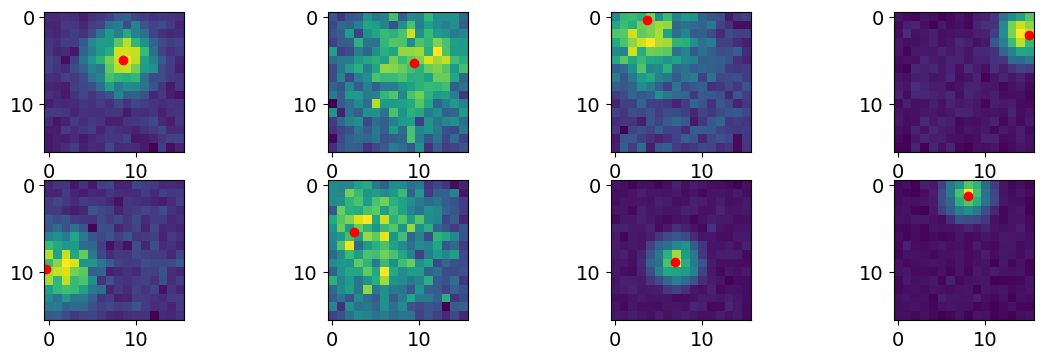

In [27]:
plot_images(imgs, mdata, range(0,8), pixel_size = 3, grid_size=16)

In [28]:
energy = get_energy(crystal, 9)

Selected files: img = images_10.npy, metdata = metadata_10.csv


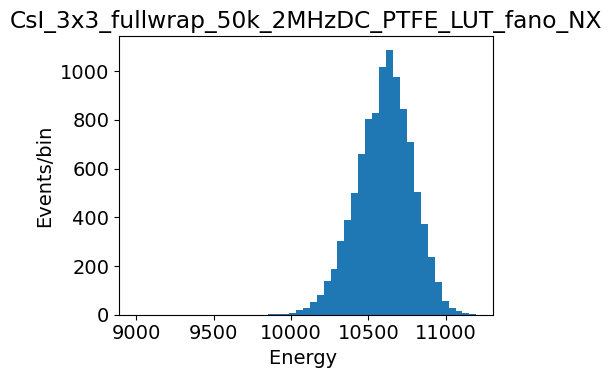

In [29]:
plot_energies2({"CsI_3x3_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX":energy}, xmin=9000, xmax=max(energy),num_bins = 50)

In [30]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} sigma = {100*std6x6:.2f} % FWHM = {100*fwhm6x6:.2f} %")

mean = 10602.78 sigma = 1.68 % FWHM = 3.86 %


## Short run
- Use a fraction (1/3) of data set.
- No normalization

In [31]:
first_file = 0  # initial file indx
last_file  = 30  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [32]:
# xyze = True for new data sets where the csv includes (x,y,z,nphot) but the network 
# compares with xyz. For old data sets (x,y,z) or new data sets comparing with a net of
# x,y,z,e output, use xyze = False (or remove, it is the default). 

dataset = MonoDataset(crystal, first_file, last_file, xyze=True)  # No comparison with energy only xyz


Running Monoataset with norm = False, resize=False, xyze=True
Loading files with indexes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
meta[1:-1] =[-17.736462   5.652053  37.049225]


In [33]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 300000 events
 train size = 210000
 val size = 60000
 test size = 30000
 train indices = range(0, 210000)
 val indices = range(210000, 270000)
 test indices = range(270000, 300000)
210000 training events (70.0%)
60000 validation events (20.0%)
30000 test events (10.0%)


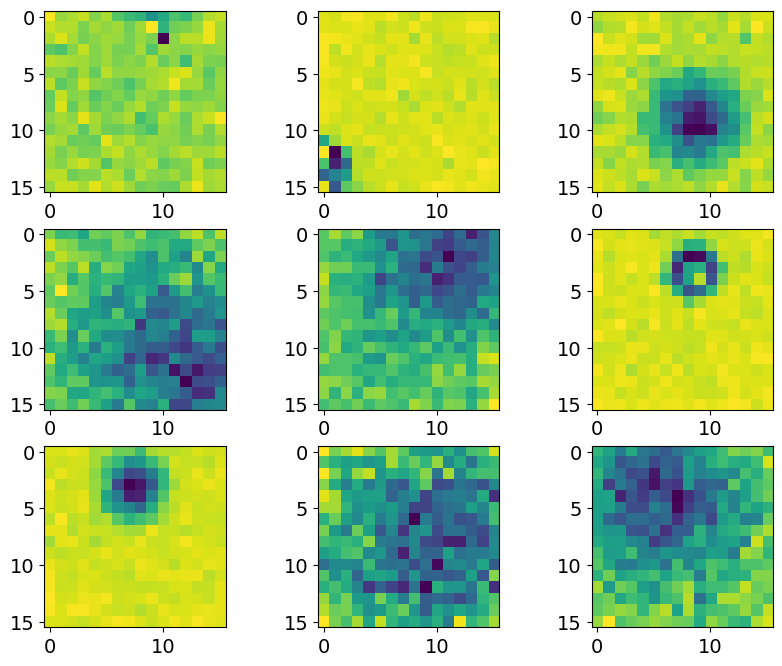

In [34]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [35]:
model_4L_3222 = CNN(CNNT3222, fc0, dropout=True).to(device)
optimizer = optim.Adam(model_4L_3222.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [37]:
single_run(train_loader, device, model_4L_3222, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 16, 16])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/210, Loss: 274.78009033203125
i = 1
images = torch.Size([1000, 1, 16, 16])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/210, Loss: 214.7303466796875


In [38]:
train_losses, val_losses = train_cnnx(train_loader, val_loader,
                                    model_4L_3222, optimizer, device, criterion, 
                                    batch_size, epochs=10, iprnt=2000)

Training with  ->210000 images
size of train loader  ->210 images
Evaluating with  ->60000 images
size of eval loader  ->60 images
Running for epochs ->10

EPOCH 0
images after conv = torch.Size([1000, 1, 8, 8])
images after conv = torch.Size([1000, 1, 8, 8])
images after conv = torch.Size([1000, 1, 8, 8])
--- EPOCH 0 AVG TRAIN LOSS: 16.276079227810815
--- EPOCH 0 AVG VAL LOSS: 7.378893097241719

EPOCH 1
images after conv = torch.Size([1000, 1, 8, 8])
images after conv = torch.Size([1000, 1, 8, 8])
images after conv = torch.Size([1000, 1, 8, 8])
--- EPOCH 1 AVG TRAIN LOSS: 6.521983700706845
--- EPOCH 1 AVG VAL LOSS: 5.630371228853861

EPOCH 2
images after conv = torch.Size([1000, 1, 8, 8])
images after conv = torch.Size([1000, 1, 8, 8])
images after conv = torch.Size([1000, 1, 8, 8])
--- EPOCH 2 AVG TRAIN LOSS: 5.991824729101999
--- EPOCH 2 AVG VAL LOSS: 6.123982898394266

EPOCH 3
images after conv = torch.Size([1000, 1, 8, 8])
images after conv = torch.Size([1000, 1, 8, 8])
images aft

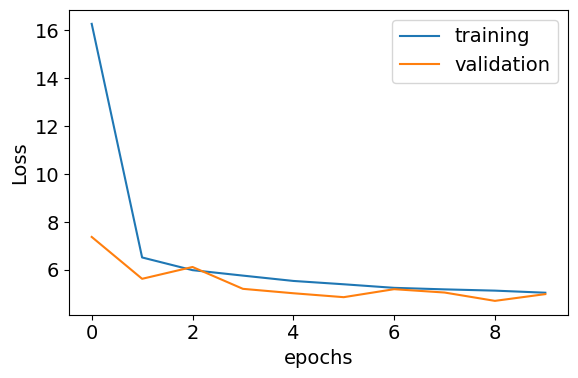

In [39]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [41]:
tdeltas = evaluate_cnnx(test_loader, model_4L_3222, device)

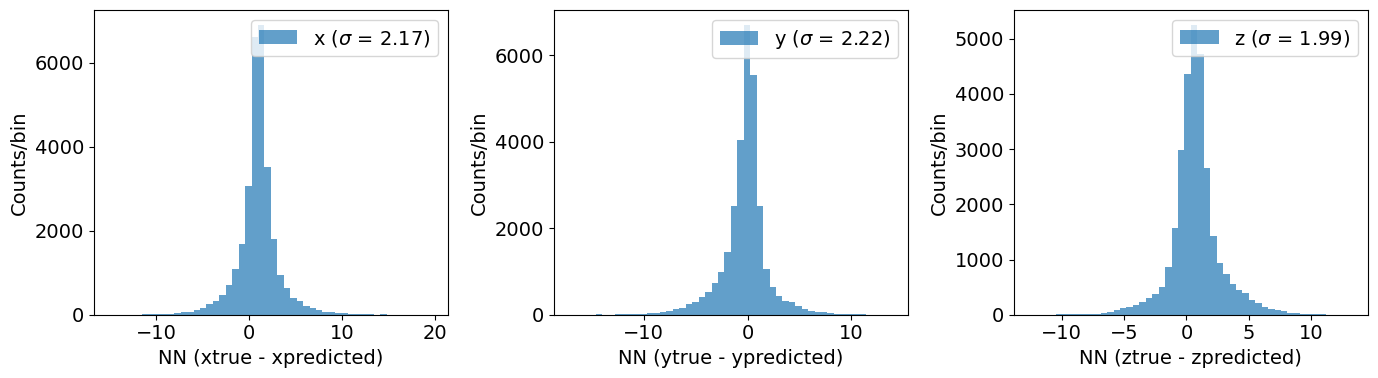

In [42]:
plotxyz(tdeltas, nbins=50)

In [43]:
f2gz, f2gx, f2gy = fit_coord(tdeltas, bins=100)

2g fit: mu1 = 0.96, sigma = 2.87, n1  =0.16
2g fit: mu2 = 0.59, sigma = 0.82, n1  =0.84
weighted error: = 1.15
2g fit: mu1 = 0.99, sigma = 0.61, n1  =0.74
2g fit: mu2 = 0.88, sigma = 2.23, n1  =0.26
weighted error: = 1.03
2g fit: mu1 = -0.56, sigma = 2.15, n1  =0.25
2g fit: mu2 = 0.11, sigma = 0.63, n1  =0.75
weighted error: = 1.01


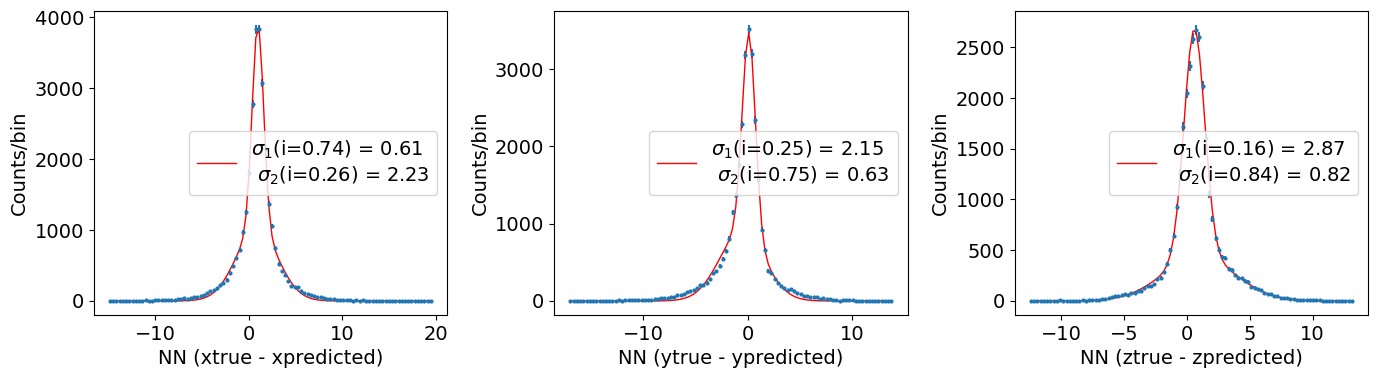

In [44]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## Normalization

In [45]:
means, stds = get_means_stds(dir=crystal)

files in dir: 98
shape -> (10000, 16, 16)
mean img0 =41.3984375
std  img0 =192.47279357910156


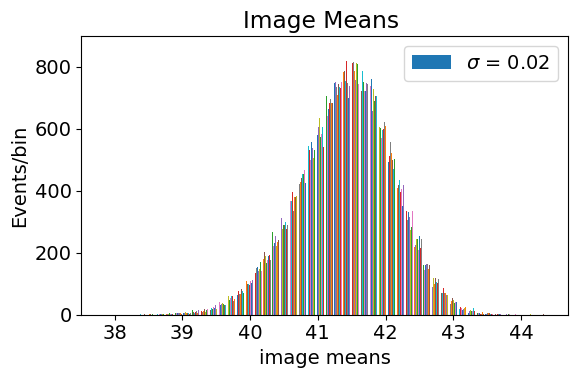

In [46]:
histoplot(means, "image means", vart="Image Means ", num_bins = 50, figsize=(6, 4))

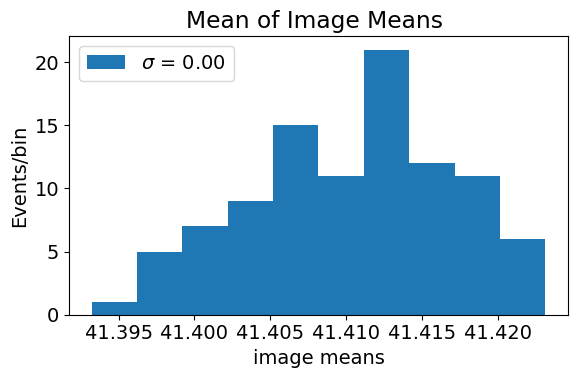

In [47]:
meansx =[np.mean(x) for x in means]
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [48]:
imean = np.mean(meansx)

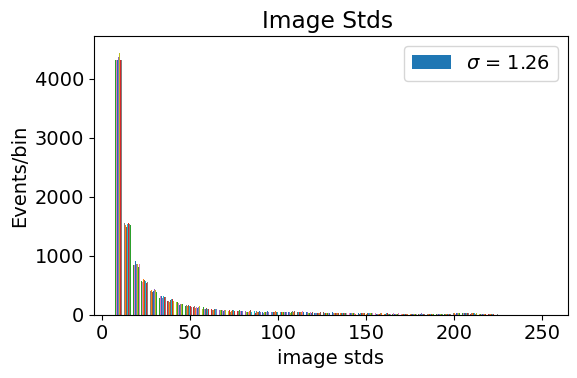

In [49]:
histoplot(stds, "image stds", vart="Image Stds ", num_bins = 50, figsize=(6, 4))

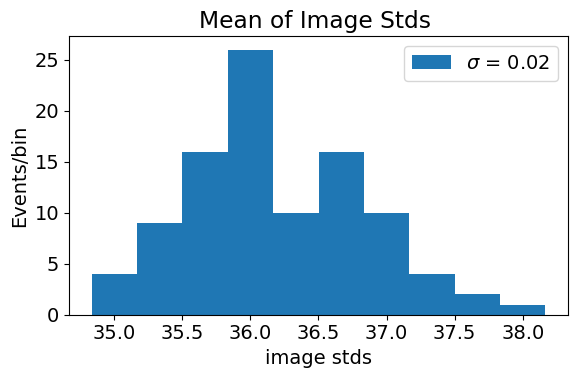

In [50]:
stdsx =[np.std(x) for x in stds]
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [51]:
isigma = np.mean(stdsx)

In [52]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 41.41035461425781, std = 36.19455337524414


### Run with full stats and normalization 

In [53]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 100  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [54]:
dataset = MonoDataset(crystal, first_file, last_file, norm=True, resize=False, mean=imean, std=isigma,xyze=True)  # No comparison with energy only xyz



Running Monoataset with norm = True, resize=False, xyze=True
Loading files with indexes: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  73
  74  75  76  77  78  79  80  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100]
meta[1:-1] =[-17.736462   5.652053  37.049225]


In [55]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 980000 events
 train size = 686000
 val size = 196000
 test size = 98000
 train indices = range(0, 686000)
 val indices = range(686000, 882000)
 test indices = range(882000, 980000)
686000 training events (70.0%)
196000 validation events (20.0%)
98000 test events (10.0%)


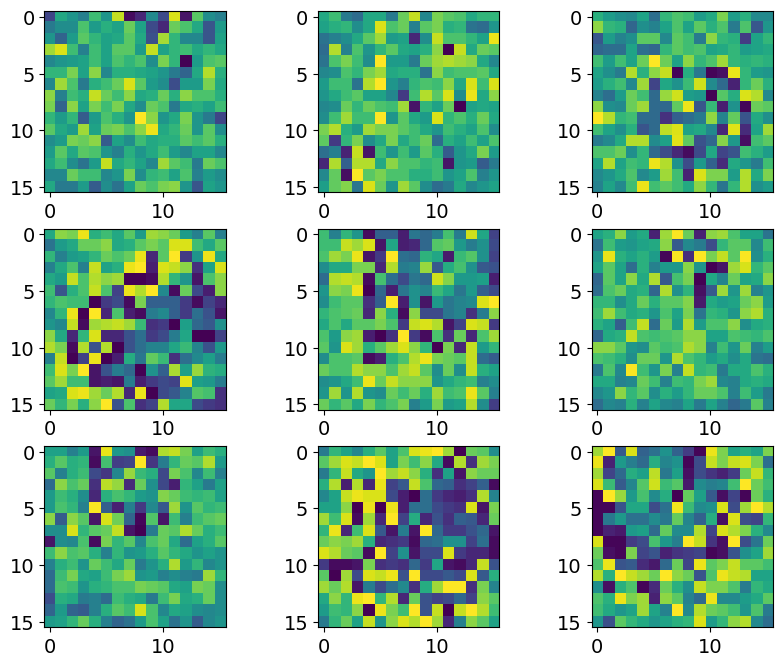

In [56]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [57]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model_4L_3222, optimizer, device, criterion, 
                                    batch_size, epochs=10, iprnt=2000)

Training with  ->686000 images
size of train loader  ->6860 images
Evaluating with  ->196000 images
size of eval loader  ->1960 images
Running for epochs ->10

EPOCH 0
Train Step 2000/6860, Loss: 5.819910526275635
Train Step 4000/6860, Loss: 6.177231788635254
Train Step 6000/6860, Loss: 5.571113586425781
--- EPOCH 0 AVG TRAIN LOSS: 6.675072576944056
--- EPOCH 0 AVG VAL LOSS: 4.996969128628167

EPOCH 1
Train Step 2000/6860, Loss: 4.981395721435547
Train Step 4000/6860, Loss: 7.197575092315674
Train Step 6000/6860, Loss: 4.6529998779296875
--- EPOCH 1 AVG TRAIN LOSS: 5.413225560459382
--- EPOCH 1 AVG VAL LOSS: 4.549214914015361

EPOCH 2
Train Step 2000/6860, Loss: 5.735102653503418
Train Step 4000/6860, Loss: 4.09763765335083
Train Step 6000/6860, Loss: 5.999630451202393
--- EPOCH 2 AVG TRAIN LOSS: 5.108148657893301
--- EPOCH 2 AVG VAL LOSS: 4.554781607462435

EPOCH 3
Train Step 2000/6860, Loss: 3.9300293922424316
Train Step 4000/6860, Loss: 4.3190717697143555
Train Step 6000/6860, Loss:

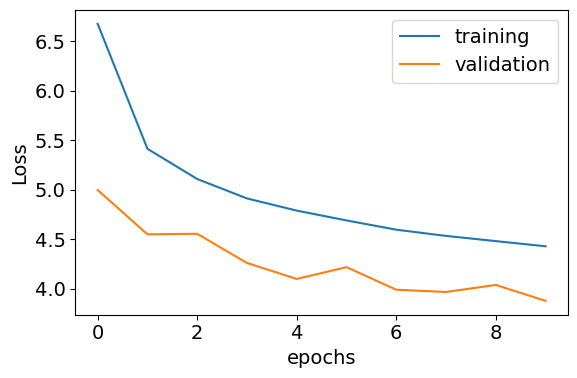

In [58]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [59]:
tdeltas = evaluate_cnn(test_loader, model_4L_3222, device, pixel_size = 3, energy=False)

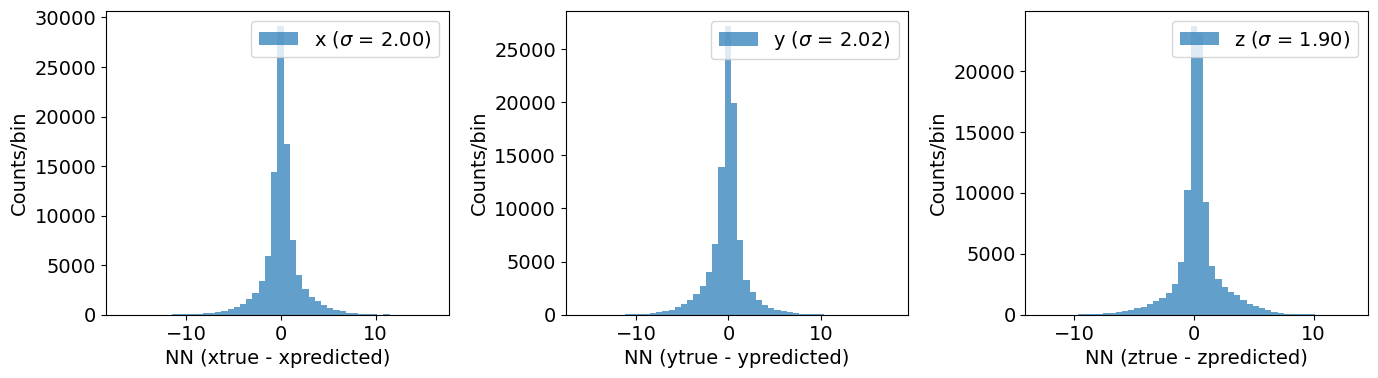

In [60]:
plotxyz(tdeltas, nbins=50)

### Deeper network

In [61]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out

In [62]:
class ResNet10(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image passes through a convolution (kernel 3x3) 
    with stride = 1 and padding = 1 which increases the features from 3 to 64 and 
    preserves spatian dimensions, then batch normalization and activation. 
    # (W,H,1) => (W,H,64)
    
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, num_classes = 3, dropout=False, dropout_fraction=0.2, debug=False):
        super(ResNet10, self).__init__()
        self.debug = debug
        self.inplanes = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, 2)
        self.layer0 = self._make_layer(block, 64, 1, stride = 1, nlyr = 1)
        self.layer1 = self._make_layer(block, 128, 1, stride = 2, nlyr = 2)
        self.layer2 = self._make_layer(block, 256, 1, stride = 2, nlyr = 3)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2, nlyr = 4)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)

           
    def _make_layer(self, block, planes, blocks, stride, nlyr):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer {nlyr}: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            #print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    def forward(self, x):
        if(self.debug): print(f" ResNet10: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet10: after conv1 =>{x.shape}")
            
        #x = self.maxpool(x)
        #if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet10: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet10: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet10: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet10: after layer3 =>{x.shape}")
            
        x = self.pool(x)
        if(self.debug): print(f" ResNet10: after avgpool =>{x.shape}")

        x = x.flatten(start_dim=1)
        #x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet10: after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc(x)
        if(self.debug): print(f" ResNet10: after fc =>{x.shape}")

        self.debug = False
        return x
  

In [63]:
#define the model
modelrn = ResNet10(ResBlock, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [64]:
summary(modelrn,(1,16,16))

 ResNet10: input data shape =>torch.Size([2, 1, 16, 16])
 ResNet10: after conv1 =>torch.Size([2, 64, 16, 16])
 ResNet10: after layer0 =>torch.Size([2, 64, 16, 16])
 ResNet10: after layer1 =>torch.Size([2, 128, 8, 8])
 ResNet10: after layer2 =>torch.Size([2, 256, 4, 4])
 ResNet10: after layer3 =>torch.Size([2, 512, 2, 2])
 ResNet10: after avgpool =>torch.Size([2, 512, 1, 1])
 ResNet10: after flatten =>torch.Size([2, 512])
 ResNet10: after fc =>torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]             640
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          36,928
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7 

In [65]:
optimizerrn = optim.Adam(modelrn.parameters(), lr=0.001)

In [66]:
single_run(train_loader, device, modelrn, optimizerrn,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([100, 1, 16, 16])
labels = torch.Size([100, 3])
outputs = torch.Size([100, 3])
Train Step 1/6860, Loss: 271.16668701171875
i = 1
images = torch.Size([100, 1, 16, 16])
labels = torch.Size([100, 3])
outputs = torch.Size([100, 3])
Train Step 2/6860, Loss: 231.64620971679688


In [67]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    modelrn, optimizerrn, device, criterion, 
                                    batch_size=500, epochs=10, iprnt=2000)

Training with  ->3430000 images
size of train loader  ->6860 images
Evaluating with  ->980000 images
size of eval loader  ->1960 images
Running for epochs ->10

EPOCH 0
Train Step 2000/6860, Loss: 5.824728488922119
Train Step 4000/6860, Loss: 4.730734348297119
Train Step 6000/6860, Loss: 4.270293235778809
--- EPOCH 0 AVG TRAIN LOSS: 5.574861196248246
--- EPOCH 0 AVG VAL LOSS: 3.9234352578313985

EPOCH 1
Train Step 2000/6860, Loss: 5.496000289916992
Train Step 4000/6860, Loss: 3.626014471054077
Train Step 6000/6860, Loss: 3.563673257827759
--- EPOCH 1 AVG TRAIN LOSS: 4.464049956298083
--- EPOCH 1 AVG VAL LOSS: 3.6884452086930373

EPOCH 2
Train Step 2000/6860, Loss: 4.650121688842773
Train Step 4000/6860, Loss: 5.032261848449707
Train Step 6000/6860, Loss: 5.549496173858643
--- EPOCH 2 AVG TRAIN LOSS: 4.198680238960089
--- EPOCH 2 AVG VAL LOSS: 3.399690685953413

EPOCH 3
Train Step 2000/6860, Loss: 4.268925666809082
Train Step 4000/6860, Loss: 5.444616794586182
Train Step 6000/6860, Loss

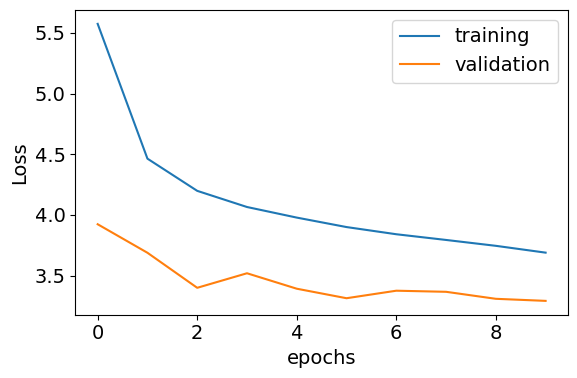

In [68]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))



In [69]:
tdeltas = evaluate_cnn(test_loader, modelrn, device, pixel_size = 3, energy=False)

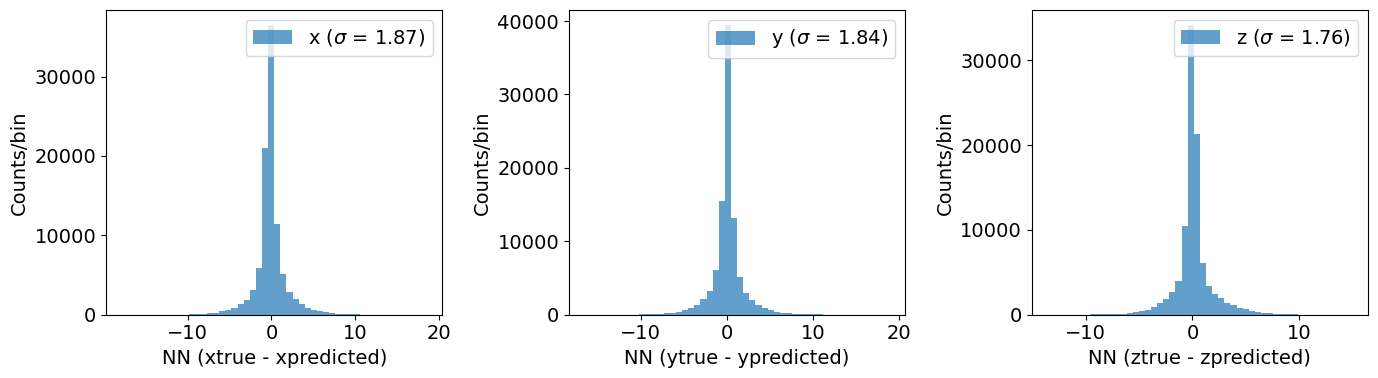

In [70]:
plotxyz(tdeltas, nbins=50)

In [71]:
f2gz, f2gx, f2gy = fit_coord(tdeltas, bins=100)

2g fit: mu1 = 0.12, sigma = 2.00, n1  =0.12
2g fit: mu2 = -0.03, sigma = 0.36, n1  =0.88
weighted error: = 0.57
2g fit: mu1 = -0.21, sigma = 0.38, n1  =0.81
2g fit: mu2 = -0.06, sigma = 1.69, n1  =0.19
weighted error: = 0.63
2g fit: mu1 = 0.07, sigma = 1.55, n1  =0.21
2g fit: mu2 = 0.09, sigma = 0.33, n1  =0.79
weighted error: = 0.59


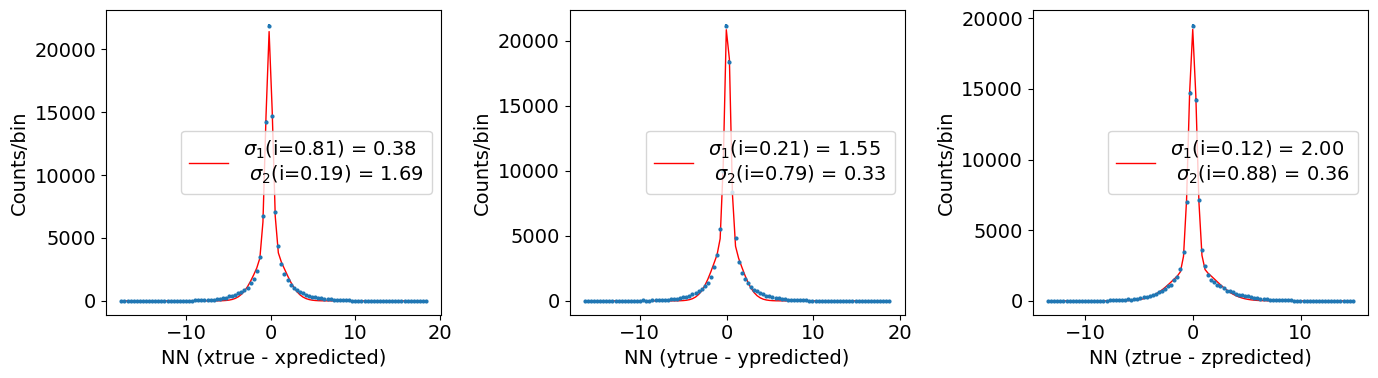

In [72]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))